# CS 199 Data Analysis

# Preliminaries

Retrieving Sheets

In [1]:
%%capture
!pip install emoji --upgrade

In [2]:
from google.colab import auth
import gspread
from google.auth import default

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition

from scipy import stats

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

pregame_response = gc.open('Pre-Game Questionnaire: Daily Data Privacy Game (Responses)').sheet1
postgame_response = gc.open('Post-Game Questionnaire: Daily Data Privacy Game (Responses)').sheet1

# get_all_values gives a list of rows.
pregame_rows = pregame_response.get_all_values()
postgame_rows = postgame_response.get_all_values()

# Create DataFrames
df_pregame = pd.DataFrame(pregame_rows[1:], columns=pregame_rows[0])
df_postgame = pd.DataFrame(postgame_rows[1:], columns=postgame_rows[0])

In [4]:
df_pregame = df_pregame.drop_duplicates('Email', keep = 'last')
df_postgame = df_postgame.drop_duplicates('Email', keep = 'last')


Responses from pre-game questionnaire.

In [5]:
df_pregame.head(2)

,Timestamp,"In compliance with the Data Privacy Act of 2012 (RA10173) and its Implementing Rules and Regulations, I am allowing Julian Dycaico and Hans Olaño from the University of the Philippines - Diliman to store and use my data as part of their research study. \n\nBy using the survey form you give us permission to collect/use your information for research purposes only.",Name,Email,Year of Birth,"In general, how much time do you spend on social media (Facebook, Tiktok, Instagram, etc. daily?",Which social media platforms do you use?,Do you know the Data Privacy Act of 2012?,"If yes, as best as you can, can you give a short description on what you know about it? If no put ""N/A"".",App Permission,Username Selection,Photo Selection,Caption Selection,Location Data,Post Visibility,Removal of Tags,Persuasive Features,Tagging Behavior
0,6/28/2023 19:06:21,"Yes, I agree and give consent",Russel Ang,russel_john01@yahoo.com,2000,Several times a day.,"Facebook, Youtube, Discord, and Twitter.",No,N/A,4,2,2,2,3,4,2,4,3
1,6/28/2023 19:12:01,"Yes, I agree and give consent",Tim,tcdy@up.edu.ph,2001,Several times a day.,"Facebook, Twitter, Instagram, YouTube",Yes,Researchers can only use the data provided by ...,4,2,3,4,4,4,4,1,4


Responses from post-game questionnaire.

In [6]:
df_postgame.head(2)

,Timestamp,"In compliance with the Data Privacy Act of 2012 (RA10173) and its Implementing Rules and Regulations, I am allowing Julian Dycaico and Hans Olaño from the University of the Philippines - Diliman to store and use my data as part of their research study. \n\nBy using the survey form you give us permission to collect/use your information for research purposes only.",Name,Email,App Permission,Username Selection,Photo Selection,Caption Selection,Location Data,Post Visibility,Removal of Tags,Persuasive Features,Tagging Behavior,Do you have any realizations you would like to share regarding the possible risks on use of social media?
0,6/28/2023 19:13:09,"Yes, I agree and give consent",Russel Ang,russel_john01@yahoo.com,5,4,3,3,5,4,3,1,3,i did not know how much a caption can reveal
1,6/28/2023 19:28:35,"Yes, I agree and give consent",,a.l.a.tecson@gmail.com,4,4,4,4,4,4,4,4,4,"Im aware of the risks, but I dont necessarily ..."


# Demographics

### Number of Responses

In [7]:
pregame_rows, pregame_columns = df_pregame.shape

print("Pregame Responses: {}\n".format(pregame_rows))

postgame_rows, postgame_columns = df_pregame.shape

print("Postgame Responses: {}".format(postgame_rows))

Pregame Responses: 43

Postgame Responses: 43


### Generational Demographic

Create new column to indicate generation demographic.

From https://libguides.usc.edu/busdem/age (https://genhq.com/the-generations-hub/generational-faqs/)


1.   Baby Boomers:                            1946 - 1964
2.   Gen X:                                   1965 - 1976
3.   Gen Y / Millennials:                           1977 - 1995
4.   Gen Z / iGen / Centennials               1996 - 2010
5.   Gen Alpha                                2010 - ?






In [8]:
# Create a new column 'Generation' based on 'Year of Birth'
df_pregame['Generation'] = pd.cut(df_pregame['Year of Birth'].astype(int), bins=[1946, 1965, 1977, 1996, 2010, 3000], labels=['Baby Boomer', 'Gen X', 'Gen Y', 'Gen Z', 'Gen Alpha'], right=False)

df_pregame.head(5)

,Timestamp,"In compliance with the Data Privacy Act of 2012 (RA10173) and its Implementing Rules and Regulations, I am allowing Julian Dycaico and Hans Olaño from the University of the Philippines - Diliman to store and use my data as part of their research study. \n\nBy using the survey form you give us permission to collect/use your information for research purposes only.",Name,Email,Year of Birth,"In general, how much time do you spend on social media (Facebook, Tiktok, Instagram, etc. daily?",Which social media platforms do you use?,Do you know the Data Privacy Act of 2012?,"If yes, as best as you can, can you give a short description on what you know about it? If no put ""N/A"".",App Permission,Username Selection,Photo Selection,Caption Selection,Location Data,Post Visibility,Removal of Tags,Persuasive Features,Tagging Behavior,Generation
0,6/28/2023 19:06:21,"Yes, I agree and give consent",Russel Ang,russel_john01@yahoo.com,2000,Several times a day.,"Facebook, Youtube, Discord, and Twitter.",No,N/A,4,2,2,2,3,4,2,4,3,Gen Z
1,6/28/2023 19:12:01,"Yes, I agree and give consent",Tim,tcdy@up.edu.ph,2001,Several times a day.,"Facebook, Twitter, Instagram, YouTube",Yes,Researchers can only use the data provided by ...,4,2,3,4,4,4,4,1,4,Gen Z
2,6/28/2023 19:18:39,"Yes, I agree and give consent",,a.l.a.tecson@gmail.com,2000,Almost constantly.,"Facebook, reddit, youtube",Yes,Simply the data that I give will remain privat...,4,4,4,4,4,4,4,4,4,Gen Z
3,6/28/2023 19:24:50,"Yes, I agree and give consent",Rianna Cruz,rscruz7@up.edu.ph,1995,Several times a day.,"Facebook, Instagram, Twitter",Yes,right to decide about our data,5,3,3,3,5,5,5,1,3,Gen Y
4,6/28/2023 19:47:22,"Yes, I agree and give consent",Hans Gabriel H. De Castro,hhdecastro@up.edu.ph,2001,Several times a day.,"Facebook, Twitter, Instagram",Yes,Before institutions can use our data for whate...,5,1,5,1,5,1,5,4,2,Gen Z


Visualize the Generation Demographic of Responses

<ipython-input-9-73afd255ac76>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


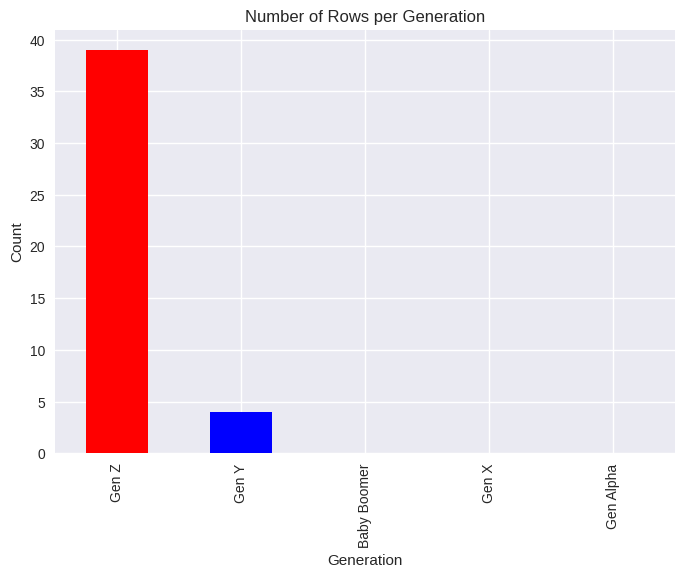

In [9]:
# Count the number of rows per generation
generation_counts = df_pregame['Generation'].value_counts()

# Define a color palette for the bars
color_palette = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

# Set the style to "seaborn"
plt.style.use('seaborn')

# Plot the bar chart with custom colors
ax = generation_counts.plot.bar(color=color_palette)

# Set plot title and axis labels
plt.title('Number of Rows per Generation')
plt.xlabel('Generation')
plt.ylabel('Count')

# Display the plot
plt.show()

In [10]:
total_generation = generation_counts.sum()

ratios = generation_counts / total_generation

print(ratios)

Gen Z          0.906977
Gen Y          0.093023
Baby Boomer    0.000000
Gen X          0.000000
Gen Alpha      0.000000
Name: Generation, dtype: float64


### Social Media Platforms

Split the responses in "Which social media platforms do you use?"


In [11]:
def extract_platforms(response):
    response = response.lower()
    platforms = re.findall(r'\b\w+\b', response)
    return platforms

In [12]:
df_pregame['Social Media Platforms'] = df_pregame['Which social media platforms do you use?'].apply(extract_platforms)

In [13]:
df_pregame['Social Media Platforms']

0            [facebook, youtube, discord, and, twitter]
1               [facebook, twitter, instagram, youtube]
2                           [facebook, reddit, youtube]
3                        [facebook, instagram, twitter]
4                        [facebook, twitter, instagram]
5                         [facebook, instagram, tiktok]
6     [facebook, twitter, tiktok, instagram, youtube...
7                        [facebook, youtube, pinterest]
8                                     [fb, ig, youtube]
9                          [facebook, twitter, discord]
10               [facebook, instagram, tiktok, twitter]
11                        [facebook, instagram, reddit]
12                                [facebook, instagram]
13                          [facebook, twitter, reddit]
14                                           [facebook]
15                                           [facebook]
16                        [facebook, tiktok, instagram]
17    [facebook, instagram, twitter, reddit, and

In [14]:
# Convert the column to a flat list and perform modifications
platforms = [platform
             for platforms_list in df_pregame['Social Media Platforms']
             for platform in platforms_list
             if platform not in ['no', 'and', 'occassionally']]  # Exclude 'no' and 'and Occasisionally'

# Combine 'fb' and 'facebook' as one platform
platforms = ['facebook' if platform in ['fb', 'facebook'] else platform for platform in platforms]

# Combine 'ig' and 'instagram' as one platform
platforms = ['instagram' if platform in ['ig', 'instagram'] else platform for platform in platforms]

platforms = [platform.capitalize() for platform in platforms]

# Count the occurrences of each platform
platform_counts = pd.Series(platforms).value_counts()

# Print the counts
print(platform_counts)

Facebook     35
Instagram    32
Twitter      26
Tiktok       12
Youtube       9
Discord       5
Reddit        5
Viber         2
Pinterest     1
Messenger     1
Telegram      1
Tumblr        1
dtype: int64


<ipython-input-15-b042f1c1aa35>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_bars)


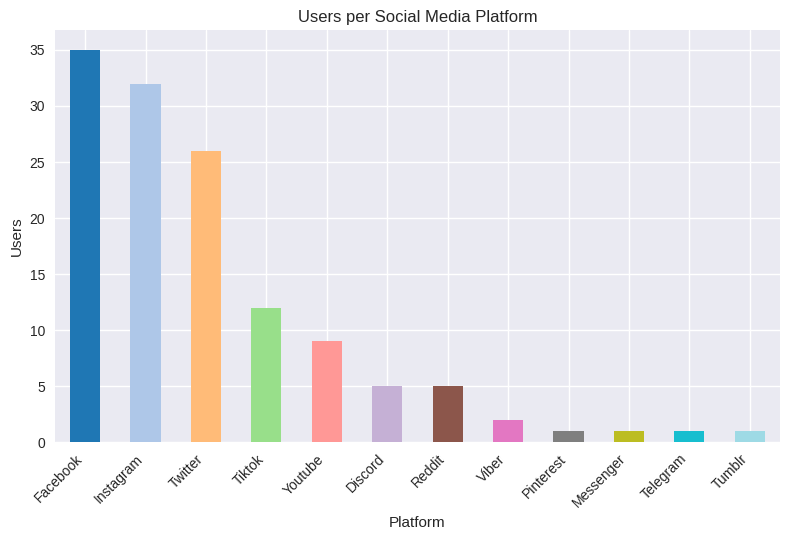

In [15]:
# Generate a unique color for each bar
num_bars = len(platform_counts)
color_palette = plt.cm.get_cmap('tab20', num_bars)

# Plot the bar chart with unique colors
fig, ax = plt.subplots()
platform_counts.plot.bar(color=color_palette(np.arange(num_bars)))

# Set the plot title and axis labels
ax.set_title('Users per Social Media Platform')
ax.set_xlabel('Platform')
ax.set_ylabel('Users')

# Adjust the spacing between x-axis tick labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

### Knowledge on the Data Privacy Act.

In [16]:
data_privacy_knowledge = df_pregame['Do you know the Data Privacy Act of 2012?']

data_privacy_counts = data_privacy_knowledge.value_counts()

data_privacy_counts

Yes    33
No     10
Name: Do you know the Data Privacy Act of 2012?, dtype: int64

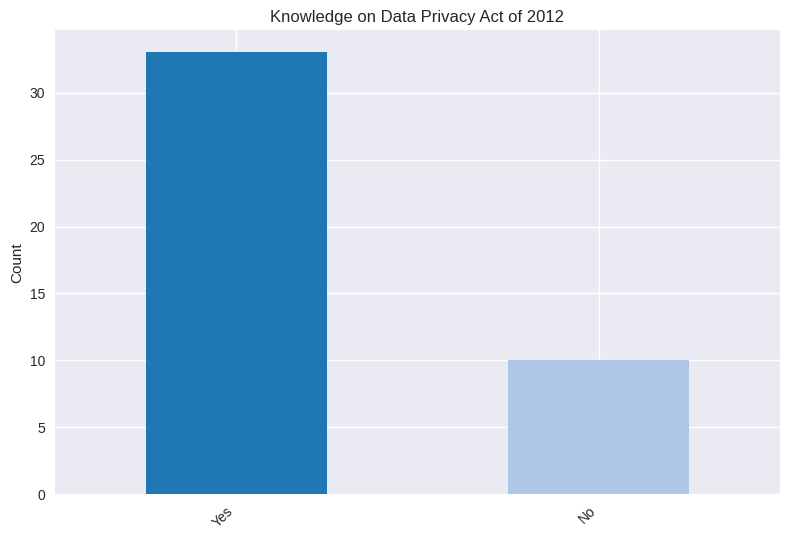

In [17]:
# Plot the bar chart with unique colors
fig, ax = plt.subplots()
data_privacy_counts.plot.bar(color=color_palette(np.arange(num_bars)))

# Set the plot title and axis labels
ax.set_title('Knowledge on Data Privacy Act of 2012')
# ax.set_xlabel('Platform')
ax.set_ylabel('Count')

# Adjust the spacing between x-axis tick labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

VADER Analysis

In [18]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [19]:
# Function for performing Topic Modelling

def topic_modeling_lda(df, column_name, n_topics=5, num_words=15):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    stop_words_eng = set(stopwords.words('english'))

    # From https://github.com/stopwords-iso/stopwords-tl
    stop_words_fil = ['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din',
    'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan',
    'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi', 'sabihin', 'sarili', 'sila', 'sino', 'siya', 'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang']

    stop_words = stop_words_eng | set(stop_words_fil)

    # Custom tokenizer
    def tokenizer(text):
        text = emoji.replace_emoji(text, replace='')  # remove emojis
        text = re.sub(r"http\S+", "", text)  # remove URLs
        text = re.sub(r"[^\w\s]", "", text)  # remove whitespaces
        tokens = [word for word in word_tokenize(text) if len(word) > 3]  # keep only 4+-length words
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words]
        # stemmed_tokens = [stemmer.stem(item) for item in tokens]
        return filtered_tokens

    # Generate features
    tf_vectorizer = TfidfVectorizer(tokenizer=tokenizer,
                                    max_df=0.75, max_features=10000,
                                    use_idf=True, norm=None, token_pattern=None)
    tf_vectors = tf_vectorizer.fit_transform(df[column_name].astype(str))

    # Create top N topics
    lda = decomposition.LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                    learning_method='online', learning_offset=50, n_jobs=1, random_state=42)
    W = lda.fit_transform(tf_vectors)
    H = lda.components_

    # Show top M relevant words for each topic
    vocab = np.array(tf_vectorizer.get_feature_names_out())
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
    topic_words = ([top_words(t) for t in H])
    topics = [' '.join(t) for t in topic_words]
    df_topics = pd.DataFrame(topics, columns=['Keywords'])
    df_topics['Topic ID'] = range(1, len(topics) + 1)

    # Perform topic composition
    doc_topic = pd.DataFrame(W, columns=["Topic"+str(i) for i in range(1, n_topics+1)])
    df_composition = pd.concat([df, doc_topic], axis=1)

    return df_topics, lda, df_composition, tf_vectorizer, tf_vectors

In [20]:
df_dpact,lda, df_composition, tf_vectorizer, tf_vectors = topic_modeling_lda(df = df_pregame, column_name = 'If yes, as best as you can, can you give a short description on what you know about it? If no put "N/A".', n_topics = 10, num_words = 15)

df_dpact

,Keywords,Topic ID
0,decide extent remain simply private give data ...,1
1,sign form whatever first institution consent m...,2
2,enacted intend information malicious tech safe...,3
3,privacy personal relation recorded properly go...,4
4,information communication individual sector pe...,5
5,help regulate recording people collection safe...,6
6,data personal know without party prohibiting d...,7
7,data platform access study different personal ...,8
8,must data privacy purpose used collected prote...,9
9,information legal right like research responde...,10


# Scores

Combine df to see if score of respondents improved.

In [21]:
# Column Names of Concepts
concepts = ['App Permission',	'Username Selection',	'Photo Selection',	'Caption Selection',	'Location Data',	'Post Visibility',	'Removal of Tags',	'Persuasive Features',	'Tagging Behavior']

### Scores Summary

In [22]:
import pandas as pd
import numpy as np

# Assuming you have the DataFrames df_pregame and df_postgame

# Merge the DataFrames using the Email column as the key
df_merged = pd.merge(df_pregame, df_postgame, on='Email')

# Create a new DataFrame to store the results
df_improvement = pd.DataFrame()

# Add the Email column as the first column
df_improvement['Email'] = df_merged['Email']

# Iterate over the concepts
for concept in concepts:
    # Extract the columns for the current concept from the merged DataFrame
    pregame_scores = df_merged[f'{concept}_x']
    postgame_scores = df_merged[f'{concept}_y']

    # Compare the scores and create a new column indicating improvement
    improvement = np.where(postgame_scores > pregame_scores, 'Improved', np.where(postgame_scores == pregame_scores, 'Unchanged', 'Lowered'))

    # Add the improvement column to the results DataFrame
    df_improvement[f'{concept} Improvement'] = improvement

# Add a new column for overall improvement
overall_improvement = df_improvement.iloc[:, 1:-1].mode(axis=1, dropna=False).iloc[:, 0].fillna('No Improvement')
df_improvement['Overall Improvement'] = overall_improvement

# View the results
df_improvement



,Email,App Permission Improvement,Username Selection Improvement,Photo Selection Improvement,Caption Selection Improvement,Location Data Improvement,Post Visibility Improvement,Removal of Tags Improvement,Persuasive Features Improvement,Tagging Behavior Improvement,Overall Improvement
0,russel_john01@yahoo.com,Improved,Improved,Improved,Improved,Improved,Unchanged,Improved,Lowered,Unchanged,Improved
1,tcdy@up.edu.ph,Improved,Improved,Improved,Improved,Improved,Improved,Improved,Improved,Improved,Improved
2,a.l.a.tecson@gmail.com,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged
3,rscruz7@up.edu.ph,Unchanged,Improved,Improved,Improved,Unchanged,Unchanged,Unchanged,Improved,Unchanged,Improved
4,hhdecastro@up.edu.ph,Unchanged,Improved,Unchanged,Improved,Unchanged,Improved,Unchanged,Improved,Improved,Improved
5,yuan_dumandan@dlsu.edu.ph,Unchanged,Improved,Improved,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged,Unchanged
6,karlostuazon@gmail.com,Improved,Unchanged,Unchanged,Improved,Improved,Improved,Improved,Improved,Improved,Improved
7,jsdoros1@up.edu.ph,Improved,Improved,Improved,Improved,Improved,Improved,Unchanged,Unchanged,Unchanged,Improved
8,cllopez3@up.edu.ph,Improved,Improved,Lowered,Improved,Unchanged,Unchanged,Improved,Improved,Improved,Improved
9,gilliancruz801@gmail.com,Lowered,Lowered,Lowered,Lowered,Lowered,Lowered,Lowered,Lowered,Lowered,Lowered


In [23]:
for concept in concepts:
    # Count the number of respondents who improved vs lowered
    improvement_counts = df_improvement[f'{concept} Improvement'].value_counts()

    # Reindex the value counts in the desired order
    improvement_counts = improvement_counts.reindex(['Improved', 'Unchanged', 'Lowered'])

    # Print the formatted value counts
    print(improvement_counts)


Improved     12
Unchanged    21
Lowered       2
Name: App Permission Improvement, dtype: int64
Improved     19
Unchanged    14
Lowered       2
Name: Username Selection Improvement, dtype: int64
Improved     12
Unchanged    20
Lowered       3
Name: Photo Selection Improvement, dtype: int64
Improved     21
Unchanged    12
Lowered       2
Name: Caption Selection Improvement, dtype: int64
Improved      7
Unchanged    24
Lowered       4
Name: Location Data Improvement, dtype: int64
Improved      9
Unchanged    23
Lowered       3
Name: Post Visibility Improvement, dtype: int64
Improved     14
Unchanged    18
Lowered       3
Name: Removal of Tags Improvement, dtype: int64
Improved     13
Unchanged    18
Lowered       4
Name: Persuasive Features Improvement, dtype: int64
Improved     16
Unchanged    14
Lowered       5
Name: Tagging Behavior Improvement, dtype: int64


In [24]:
improved = []
unchanged = []
lowered = []

for concept in concepts:
    # Count the number of respondents who improved vs lowered
    improvement_counts = df_improvement[f'{concept} Improvement'].value_counts()

    # Reindex the value counts in the desired order
    improvement_counts = improvement_counts.reindex(['Improved', 'Unchanged', 'Lowered'])

    # Calculate the ratio of each improvement level over the total population
    total_population = improvement_counts.sum()
    improvement_ratios = improvement_counts / total_population *100

    # Store the counts in respective lists
    improved.append(improvement_counts['Improved'])
    unchanged.append(improvement_counts['Unchanged'])
    lowered.append(improvement_counts['Lowered'])

    # Print the formatted improvement ratios
    print(improvement_ratios)


Improved     34.285714
Unchanged    60.000000
Lowered       5.714286
Name: App Permission Improvement, dtype: float64
Improved     54.285714
Unchanged    40.000000
Lowered       5.714286
Name: Username Selection Improvement, dtype: float64
Improved     34.285714
Unchanged    57.142857
Lowered       8.571429
Name: Photo Selection Improvement, dtype: float64
Improved     60.000000
Unchanged    34.285714
Lowered       5.714286
Name: Caption Selection Improvement, dtype: float64
Improved     20.000000
Unchanged    68.571429
Lowered      11.428571
Name: Location Data Improvement, dtype: float64
Improved     25.714286
Unchanged    65.714286
Lowered       8.571429
Name: Post Visibility Improvement, dtype: float64
Improved     40.000000
Unchanged    51.428571
Lowered       8.571429
Name: Removal of Tags Improvement, dtype: float64
Improved     37.142857
Unchanged    51.428571
Lowered      11.428571
Name: Persuasive Features Improvement, dtype: float64
Improved     45.714286
Unchanged    40.000

In [25]:
print(max(improved))
print(max(unchanged))
print(max(lowered))

21
24
5


### Improvement Status for Each Concept

<ipython-input-26-45fc0fe24869>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


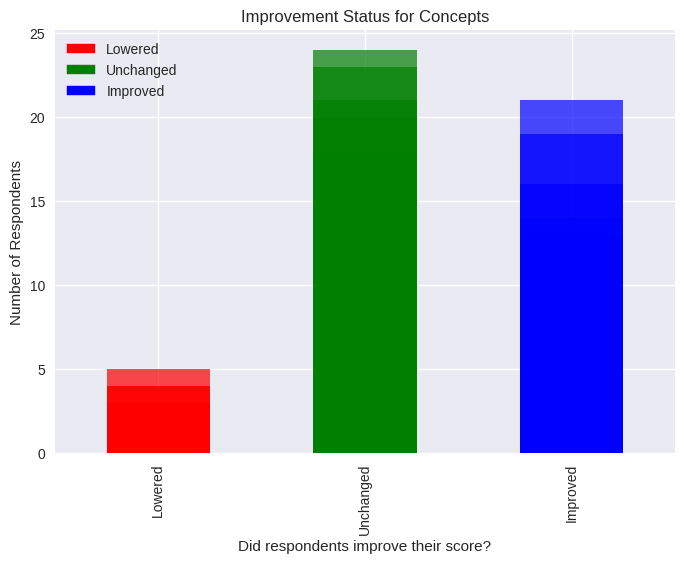

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame df_improvement

# Select a desired style for the plot
plt.style.use('seaborn')

# Create a list of improvement statuses
improvement_statuses = ['Lowered', 'Unchanged', 'Improved']

# Define colors for each improvement status
colors = ['red', 'green', 'blue']

# Create a figure and axis object
fig, ax = plt.subplots()

# Iterate over the concepts
for concept in concepts:
    # Count the number of respondents who improved vs lowered
    improvement_counts = df_improvement[f'{concept} Improvement'].value_counts()

    # Plot the bar chart with custom colors
    improvement_counts.reindex(improvement_statuses).plot(kind='bar', color=colors, ax=ax, alpha=0.7)

# Set the plot title and labels
plt.title("Improvement Status for Concepts")
plt.xlabel("Did respondents improve their score?")
plt.ylabel("Number of Respondents")

# Create a legend based on the improvement statuses
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_elements, improvement_statuses)

# Show the plot
plt.show()


<ipython-input-27-df40265dad55>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


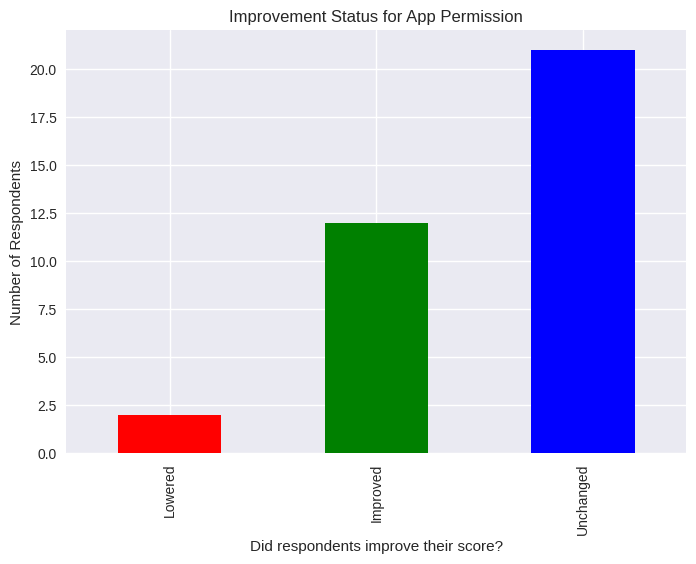

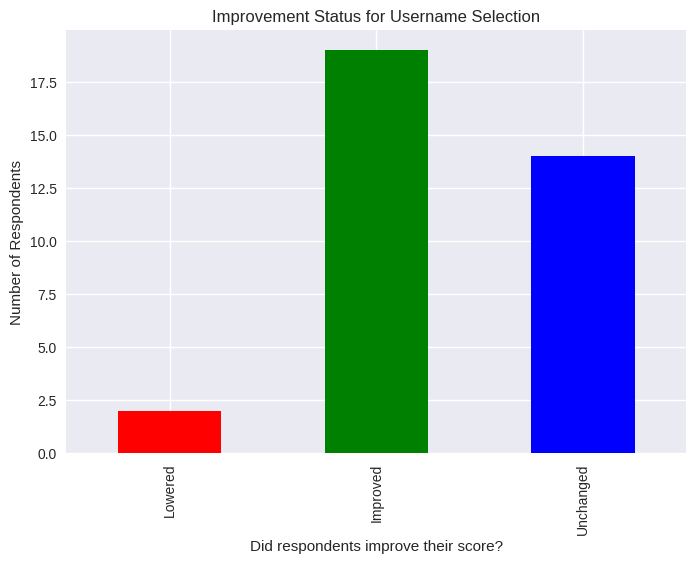

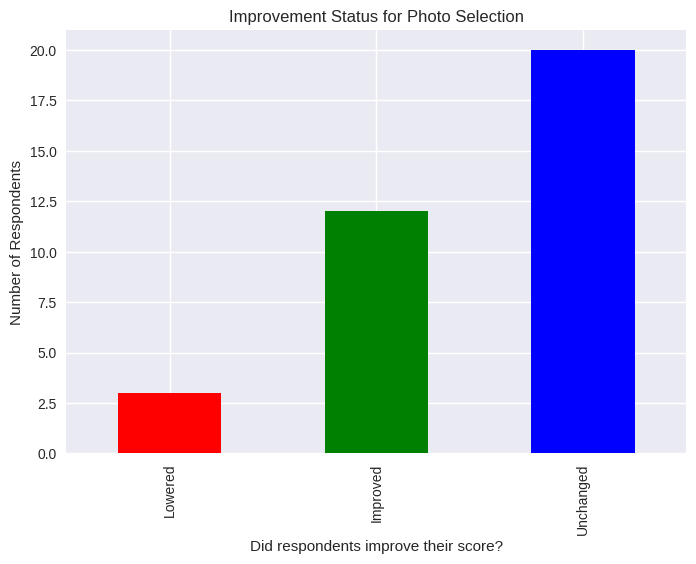

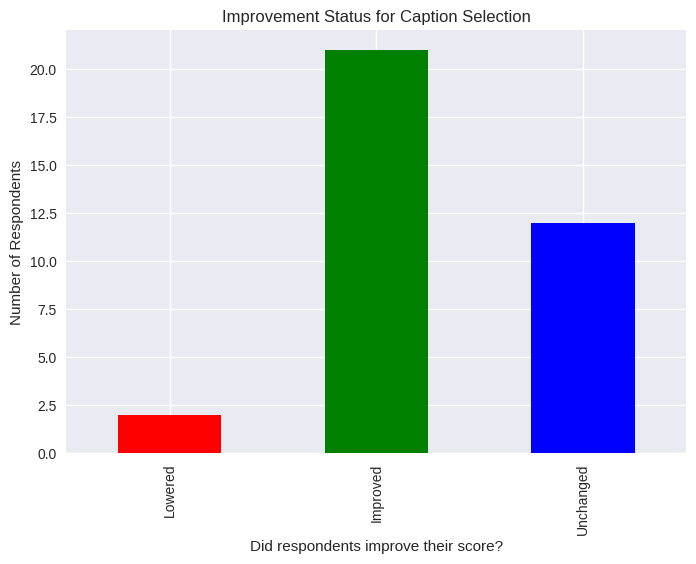

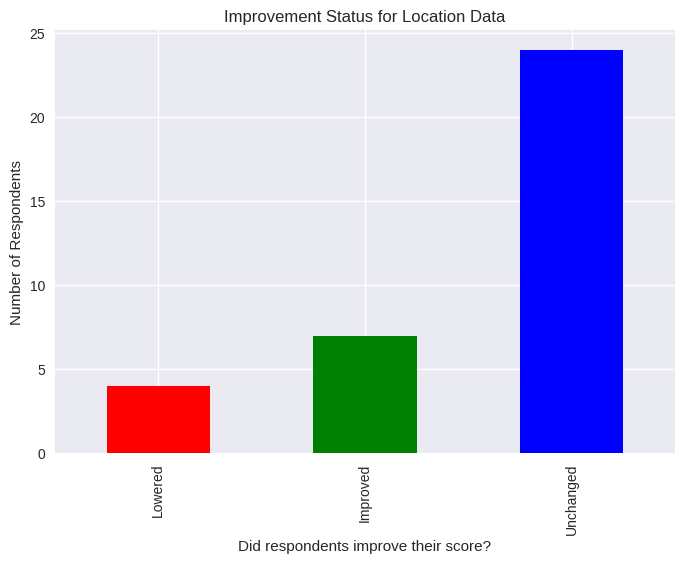

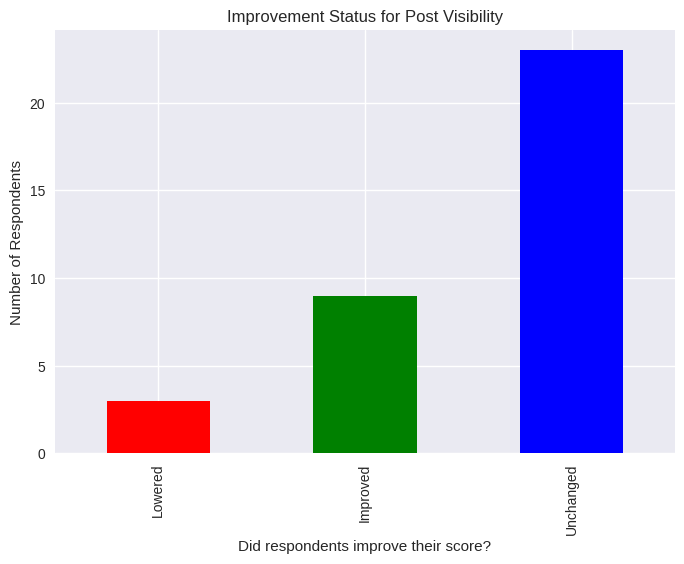

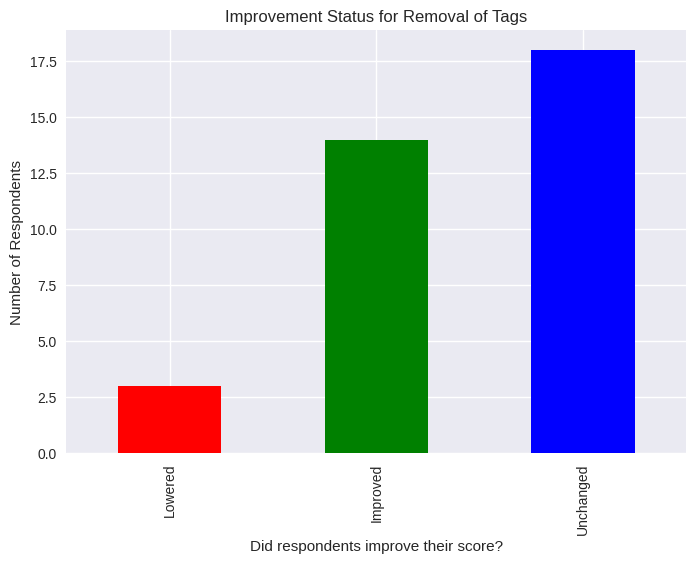

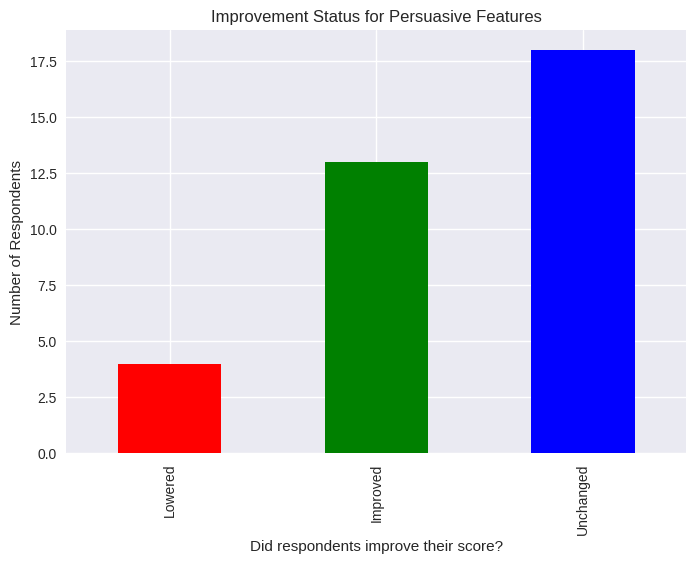

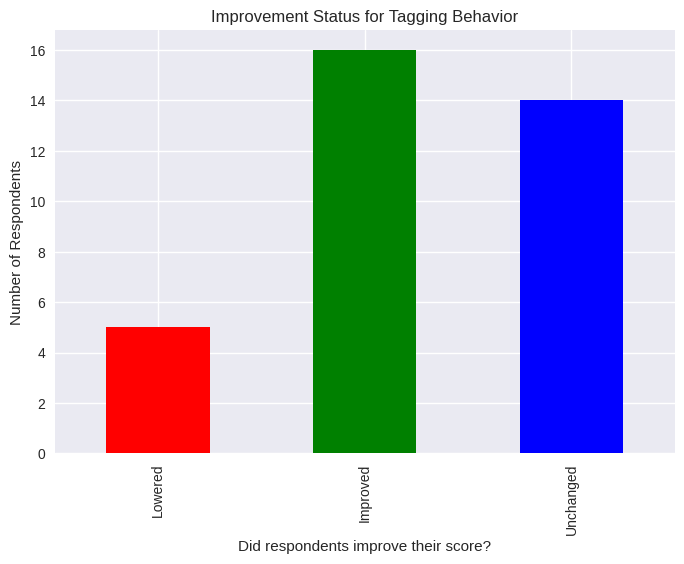

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame df_improvement

# Select a desired style for the plot
plt.style.use('seaborn')

# Create a list of improvement statuses
improvement_statuses = ['Lowered', 'Improved', 'Unchanged']

# Define colors for each improvement status
colors = ['red', 'green', 'blue']

# Iterate over the concepts
for concept in concepts:
    # Count the number of respondents who improved vs lowered
    improvement_counts = df_improvement[f'{concept} Improvement'].value_counts()

    # Plot the bar chart with custom colors
    plt.figure()
    improvement_counts.reindex(improvement_statuses).plot(kind='bar', color=colors)

    # Set the plot title and labels
    plt.title(f"Improvement Status for {concept}")
    plt.xlabel("Did respondents improve their score?")
    plt.ylabel("Number of Respondents")

    # Show the plot
    plt.show()


<ipython-input-28-30aa48cc5b19>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


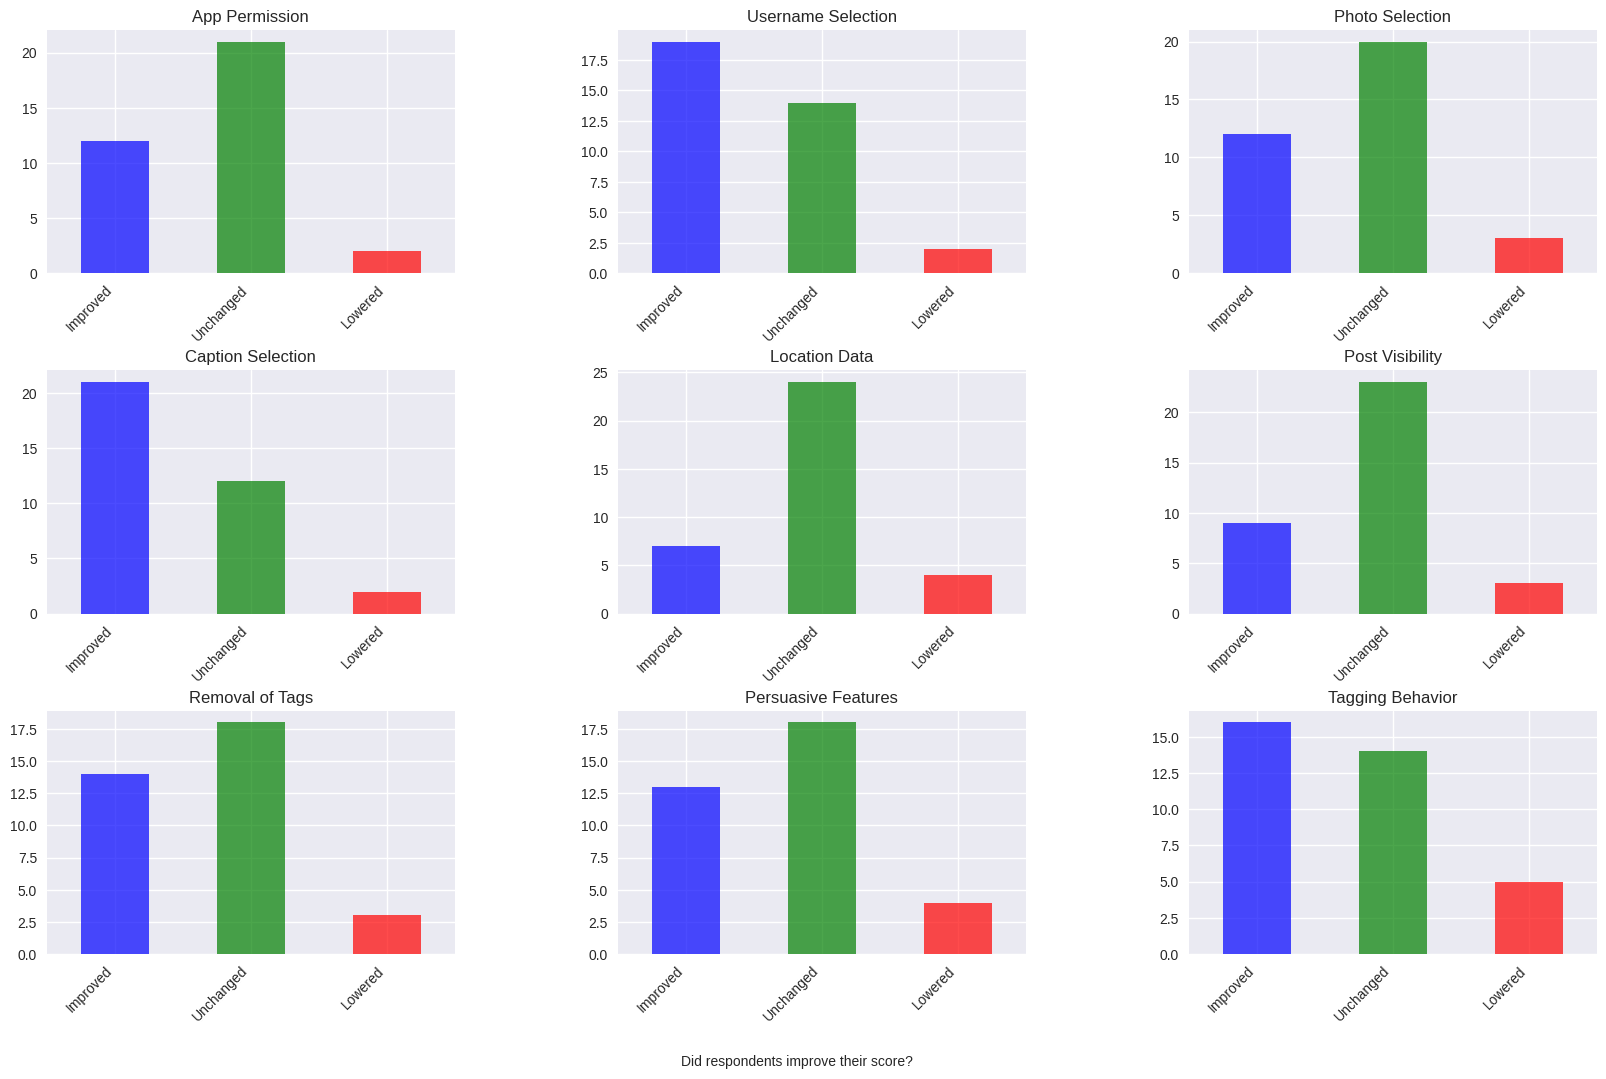

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame df_improvement

# Select a desired style for the plot
plt.style.use('seaborn')

# Create a list of improvement statuses
improvement_statuses = ['Improved', 'Unchanged', 'Lowered']

# Define colors for each improvement status
colors = ['blue', 'green', 'red']

# Calculate the number of rows and columns for the subplots
num_rows = (len(concepts) + 2) // 3  # Round up to the nearest integer
num_cols = min(len(concepts), 3)

# Create a figure and axis objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

# Iterate over rows and columns
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col  # Calculate the index for the current subplot

        if idx < len(concepts):
            concept = concepts[idx]  # Get the corresponding concept

            # Create a bar chart for the current concept
            ax = axs[row, col]
            improvement_counts = df_improvement[f'{concept} Improvement'].value_counts()
            improvement_counts.reindex(improvement_statuses).plot(kind='bar', color=colors, ax=ax, alpha=0.7)
            ax.set_title(f"{concept}")

            # Rotate the x-axis tick labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Set common x-label and y-label for the entire figure
fig.text(0.5, 0.02, "Did respondents improve their score?", ha='center', va='center')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Show the plot
plt.show()


In [29]:
### Overall Improvement

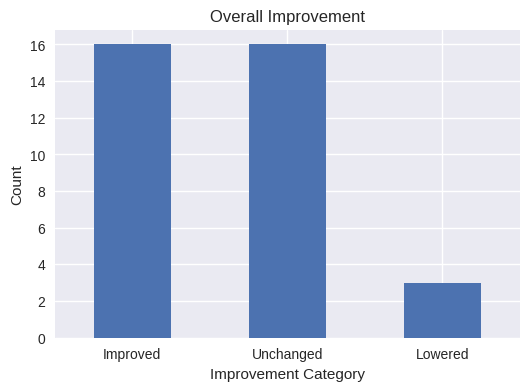

In [30]:
import matplotlib.pyplot as plt

# Count the occurrences of each improvement category
improvement_counts = df_improvement['Overall Improvement'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
improvement_counts.plot(kind='bar')
plt.xlabel('Improvement Category')
plt.ylabel('Count')
plt.title('Overall Improvement')
plt.xticks(rotation=0)
plt.show()

In [31]:
improvement_counts

Improved     16
Unchanged    16
Lowered       3
Name: Overall Improvement, dtype: int64

# Pre-Game and Post-Game Means

Get difference of pre-game and post-game responses for each concept.

In [32]:
email_intersection = list(set(df_pregame['Email']) & set(df_postgame['Email']))

len(email_intersection)

35

In [33]:
# Step 2: Filter df_pregame based on email intersection
df_pregame = df_pregame[df_pregame['Email'].isin(email_intersection)]

# Step 3: Filter df_postgame based on email intersection
df_postgame = df_postgame[df_postgame['Email'].isin(email_intersection)]

In [34]:
df_pregame.shape

(35, 20)

In [35]:
df_postgame.shape

(35, 14)

In [36]:
pre_game_means = []
post_game_means = []

pregame_std = []
postgame_std = []

difference_of_means = []

### App Permission

In [37]:
# app permission = app_perm

# Get results from both questionnaires
app_perm_pregame = df_pregame['App Permission'].astype(int)
app_perm_postgame = df_postgame['App Permission'].astype(int)

# Means of each questionnaire
app_perm_pregame_mean = app_perm_pregame.mean()
app_perm_postgame_mean = app_perm_postgame.mean()

# Means
pre_game_means.append(app_perm_pregame_mean)
post_game_means.append(app_perm_postgame_mean)

# Standard Deviation
pregame_std.append(app_perm_pregame.std())
postgame_std.append(app_perm_postgame.std())

# Subtract means
app_perm_mean = app_perm_postgame.mean() - app_perm_pregame.mean()
difference_of_means.append(app_perm_mean)

print("Average Scores on App Permissions from Pre-Game Questionnaire: {}".format(app_perm_pregame_mean))
print("Average Scores on App Permissions from Post-Game Questionnaire: {}".format(app_perm_postgame_mean))
print("Difference of Averages on App Permissions: {}".format(app_perm_mean))

Average Scores on App Permissions from Pre-Game Questionnaire: 4.457142857142857
Average Scores on App Permissions from Post-Game Questionnaire: 4.857142857142857
Difference of Averages on App Permissions: 0.39999999999999947


### Username Selection

In [38]:
# Get results from both questionnaires
username_pregame = df_pregame['Username Selection'].astype(int)
username_postgame = df_postgame['Username Selection'].astype(int)

# Means of each questionnaire
username_pregame_mean = username_pregame.mean()
username_postgame_mean = username_postgame.mean()

pre_game_means.append(username_pregame_mean)
post_game_means.append(username_postgame_mean)

pregame_std.append(username_pregame.std())
postgame_std.append(username_postgame.std())

# Subtract means
username_mean = username_postgame.mean() - username_pregame.mean()
difference_of_means.append(username_mean)

print("Average Scores on Username Selection from Pre-Game Questionnaire: {}".format(username_pregame_mean))
print("Average Scores on Username Selection from Post-Game Questionnaire: {}".format(username_postgame_mean))
print("Difference of Averages on Username Selection: {}".format(username_mean))

Average Scores on Username Selection from Pre-Game Questionnaire: 3.4285714285714284
Average Scores on Username Selection from Post-Game Questionnaire: 4.4
Difference of Averages on Username Selection: 0.971428571428572


### Photo Selection

In [39]:
# Get results from both questionnaires
photo_pregame = df_pregame['Photo Selection'].astype(int)
photo_postgame = df_postgame['Photo Selection'].astype(int)

# Means of each questionnaire
photo_pregame_mean = photo_pregame.mean()
photo_postgame_mean = photo_postgame.mean()

pre_game_means.append(photo_pregame_mean)
post_game_means.append(photo_postgame_mean)

pregame_std.append(photo_pregame.std())
postgame_std.append(photo_postgame.std())

# Subtract means
photo_mean = photo_postgame.mean() - photo_pregame.mean()
difference_of_means.append(photo_mean)

print("Average Scores on Photo Selection from Pre-Game Questionnaire: {}".format(photo_pregame_mean))
print("Average Scores on Photo Selection from Post-Game Questionnaire: {}".format(photo_postgame_mean))
print("Difference of Averages on Photo Selection: {}".format(photo_mean))

Average Scores on Photo Selection from Pre-Game Questionnaire: 4.171428571428572
Average Scores on Photo Selection from Post-Game Questionnaire: 4.571428571428571
Difference of Averages on Photo Selection: 0.39999999999999947


### Caption Selection

In [40]:
# Get results from both questionnaires
caption_pregame = df_pregame['Caption Selection'].astype(int)
caption_postgame = df_postgame['Caption Selection'].astype(int)

# Means of each questionnaire
caption_pregame_mean = caption_pregame.mean()
caption_postgame_mean = caption_postgame.mean()

pre_game_means.append(caption_pregame_mean)
post_game_means.append(caption_postgame_mean)

pregame_std.append(caption_pregame.std())
postgame_std.append(caption_postgame.std())

# Subtract means
caption_mean = caption_postgame.mean() - caption_pregame.mean()
difference_of_means.append(caption_mean)

print("Average Scores on Caption Selection from Pre-Game Questionnaire: {}".format(caption_pregame_mean))
print("Average Scores on Caption Selection from Post-Game Questionnaire: {}".format(caption_postgame_mean))
print("Difference of Averages on Caption Selection: {}".format(caption_mean))

Average Scores on Caption Selection from Pre-Game Questionnaire: 3.3142857142857145
Average Scores on Caption Selection from Post-Game Questionnaire: 4.514285714285714
Difference of Averages on Caption Selection: 1.1999999999999997


### Location Data

In [41]:
# Get results from both questionnaires
location_data_pregame = df_pregame['Location Data'].astype(int)
location_data_postgame = df_postgame['Location Data'].astype(int)

# Means of each questionnaire
location_data_pregame_mean = location_data_pregame.mean()
location_data_postgame_mean = location_data_postgame.mean()

pre_game_means.append(location_data_pregame_mean)
post_game_means.append(location_data_postgame_mean)

pregame_std.append(location_data_pregame.std())
postgame_std.append(location_data_postgame.std())

# Subtract means
location_data_mean = location_data_postgame.mean() - location_data_pregame.mean()
difference_of_means.append(location_data_mean)

print("Average Scores on Location Data from Pre-Game Questionnaire: {}".format(location_data_pregame_mean))
print("Average Scores on Location Data from Post-Game Questionnaire: {}".format(location_data_postgame_mean))
print("Difference of Averages on Location Data: {}".format(location_data_mean))

Average Scores on Location Data from Pre-Game Questionnaire: 4.571428571428571
Average Scores on Location Data from Post-Game Questionnaire: 4.685714285714286
Difference of Averages on Location Data: 0.11428571428571477


### Post Visibility

In [42]:
# Get results from both questionnaires
post_visibility_pregame = df_pregame['Post Visibility'].astype(int)
post_visibility_postgame = df_postgame['Post Visibility'].astype(int)

# Means of each questionnaire
post_visibility_pregame_mean = post_visibility_pregame.mean()
post_visibility_postgame_mean = post_visibility_postgame.mean()

pre_game_means.append(post_visibility_pregame_mean)
post_game_means.append(post_visibility_postgame_mean)

pregame_std.append(post_visibility_pregame.std())
postgame_std.append(post_visibility_postgame.std())

# Subtract means
post_visibility_mean = post_visibility_postgame.mean() - post_visibility_pregame.mean()
difference_of_means.append(post_visibility_mean)

print("Average Scores on Post Visibility from Pre-Game Questionnaire: {}".format(post_visibility_pregame_mean))
print("Average Scores on Post Visibility from Post-Game Questionnaire: {}".format(post_visibility_postgame_mean))
print("Difference of Averages on Post Visibility: {}".format(post_visibility_mean))

Average Scores on Post Visibility from Pre-Game Questionnaire: 4.4
Average Scores on Post Visibility from Post-Game Questionnaire: 4.514285714285714
Difference of Averages on Post Visibility: 0.11428571428571388


### Removal of Tags

In [43]:
# Get results from both questionnaires
tag_removal_pregame = df_pregame['Removal of Tags'].astype(int)
tag_removal_postgame = df_postgame['Removal of Tags'].astype(int)

# Means of each questionnaire
tag_removal_pregame_mean = tag_removal_pregame.mean()
tag_removal_postgame_mean = tag_removal_postgame.mean()

pre_game_means.append(tag_removal_pregame_mean)
post_game_means.append(tag_removal_postgame_mean)

pregame_std.append(tag_removal_pregame.std())
postgame_std.append(tag_removal_postgame.std())

# Subtract means
tag_removal_mean = tag_removal_postgame.mean() - tag_removal_pregame.mean()
difference_of_means.append(tag_removal_mean)

print("Average Scores on Removal of Tags from Pre-Game Questionnaire: {}".format(tag_removal_pregame_mean))
print("Average Scores on Removal of Tags from Post-Game Questionnaire: {}".format(tag_removal_postgame_mean))
print("Difference of Averages on Removal of Tags: {}".format(tag_removal_mean))

Average Scores on Removal of Tags from Pre-Game Questionnaire: 3.8285714285714287
Average Scores on Removal of Tags from Post-Game Questionnaire: 4.457142857142857
Difference of Averages on Removal of Tags: 0.6285714285714286


### Persuasive Features

In [44]:
# Get results from both questionnaires
persuasive_features_pregame = df_pregame['Persuasive Features'].astype(int)
persuasive_features_postgame = df_postgame['Persuasive Features'].astype(int)

# Means of each questionnaire
persuasive_features_pregame_mean = persuasive_features_pregame.mean()
persuasive_features_postgame_mean = persuasive_features_postgame.mean()

pre_game_means.append(persuasive_features_pregame_mean)
post_game_means.append(persuasive_features_postgame_mean)

pregame_std.append(persuasive_features_pregame.std())
postgame_std.append(persuasive_features_postgame.std())

# Subtract means
persuasive_features_mean = persuasive_features_postgame.mean() - persuasive_features_pregame.mean()
difference_of_means.append(persuasive_features_mean)

print("Average Scores on Persuasive Features from Pre-Game Questionnaire: {}".format(persuasive_features_pregame_mean))
print("Average Scores on Persuasive Features from Post-Game Questionnaire: {}".format(persuasive_features_postgame_mean))
print("Difference of Averages on Persuasive Features: {}".format(persuasive_features_mean))

Average Scores on Persuasive Features from Pre-Game Questionnaire: 3.1142857142857143
Average Scores on Persuasive Features from Post-Game Questionnaire: 3.6
Difference of Averages on Persuasive Features: 0.48571428571428577


### Tagging Behavior

In [45]:
# Get results from both questionnaires
tagging_behavior_pregame = df_pregame['Tagging Behavior'].astype(int)
tagging_behavior_postgame = df_postgame['Tagging Behavior'].astype(int)

# Means of each questionnaire
tagging_behavior_pregame_mean = tagging_behavior_pregame.mean()
tagging_behavior_postgame_mean = tagging_behavior_postgame.mean()

pre_game_means.append(tagging_behavior_pregame_mean)
post_game_means.append(tagging_behavior_postgame_mean)

pregame_std.append(tagging_behavior_pregame.std())
postgame_std.append(tagging_behavior_postgame.std())

# Subtract means
tagging_behavior_mean = tagging_behavior_postgame.mean() - tagging_behavior_pregame.mean()
difference_of_means.append(tagging_behavior_mean)

print("Average Scores on Tagging Behavior from Pre-Game Questionnaire: {}".format(tagging_behavior_pregame_mean))
print("Average Scores on Tagging Behavior from Post-Game Questionnaire: {}".format(tagging_behavior_postgame_mean))
print("Difference of Averages on Tagging Behavior: {}".format(tagging_behavior_mean))

Average Scores on Tagging Behavior from Pre-Game Questionnaire: 3.4
Average Scores on Tagging Behavior from Post-Game Questionnaire: 4.2
Difference of Averages on Tagging Behavior: 0.8000000000000003


### Visualize Means

<ipython-input-46-601a5036f76d>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


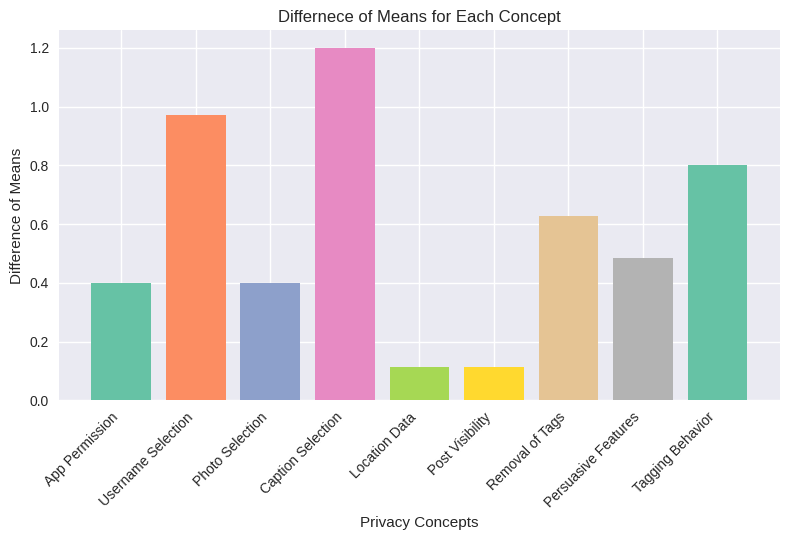

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a style (optional)
plt.style.use('seaborn')

# Use a pleasing color palette
palette = sns.color_palette('Set2', len(difference_of_means))

# Create the bar plot using plt.bar()
plt.bar(concepts, difference_of_means, color=palette)

# Add labels and title
plt.xlabel('Privacy Concepts')
plt.ylabel('Difference of Means')
plt.title('Differnece of Means for Each Concept')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Avoid label overlap
plt.tight_layout()

# Add grid
plt.grid(True)

# Adjust the figure layout
plt.tight_layout()

plt.show()


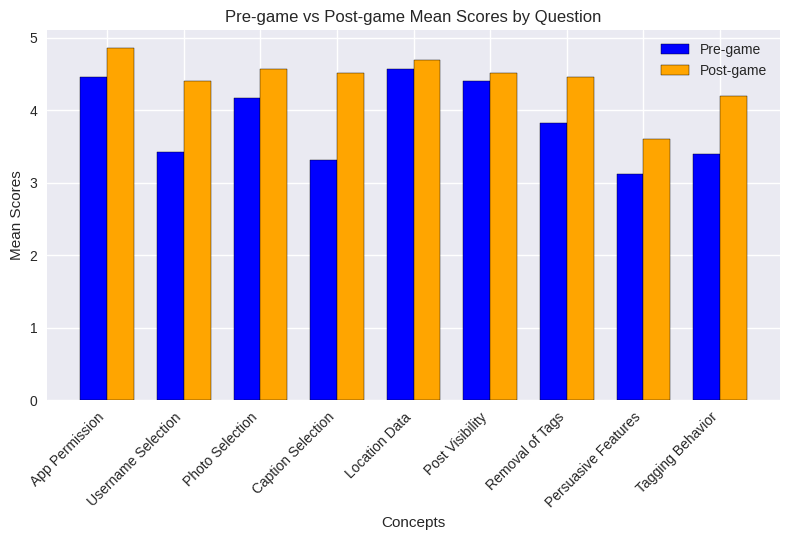

In [47]:
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(pre_game_means))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, pre_game_means, color='blue', width=bar_width, edgecolor='black', label='Pre-game')
plt.bar(r2, post_game_means, color='orange', width=bar_width, edgecolor='black', label='Post-game')

# Add labels, title, and legend
plt.xlabel('Concepts')
plt.ylabel('Mean Scores')
plt.title('Pre-game vs Post-game Mean Scores by Question')

# Rotate x-axis labels by 45 degrees
plt.xticks([r + bar_width / 2 for r in range(len(pre_game_means))], concepts, rotation=45, ha='right')

plt.legend()

# Adjust the figure layout to avoid label overlap
plt.tight_layout()

# Display the plot
plt.show()


In [48]:
for i in range(len(concepts)):
    print(f"{concepts[i]} & {round(pre_game_means[i], 4)} & {round(post_game_means[i], 4)} & {round(difference_of_means[i], 4)} \\\\ \\hline")

App Permission & 4.4571 & 4.8571 & 0.4 \\ \hline
Username Selection & 3.4286 & 4.4 & 0.9714 \\ \hline
Photo Selection & 4.1714 & 4.5714 & 0.4 \\ \hline
Caption Selection & 3.3143 & 4.5143 & 1.2 \\ \hline
Location Data & 4.5714 & 4.6857 & 0.1143 \\ \hline
Post Visibility & 4.4 & 4.5143 & 0.1143 \\ \hline
Removal of Tags & 3.8286 & 4.4571 & 0.6286 \\ \hline
Persuasive Features & 3.1143 & 3.6 & 0.4857 \\ \hline
Tagging Behavior & 3.4 & 4.2 & 0.8 \\ \hline


In [49]:
post_game_means

[4.857142857142857,
 4.4,
 4.571428571428571,
 4.514285714285714,
 4.685714285714286,
 4.514285714285714,
 4.457142857142857,
 3.6,
 4.2]

# Statistical Test

Perform One sample t-test for two correlated means

Null Hypothesis: The means of the two tests have no significant difference.
Alternate Hypothesis: The means of the two tests have a significant difference.

In [50]:
from scipy import stats

# Check for normality using Shapiro-Wilk test
_, p_pre = stats.shapiro(pre_game_means)
_, p_post = stats.shapiro(post_game_means)

# Check if data is continuous
is_continuous_pre = all(isinstance(x, (int, float)) for x in pre_game_means)
is_continuous_post = all(isinstance(x, (int, float)) for x in post_game_means)

# Print the results
print("Pre-game Means:")
print("Is Normally Distributed:", p_pre > 0.05)
print("Is Continuous:", is_continuous_pre)

print("\nPost-game Means:")
print("Is Normally Distributed:", p_post > 0.05)
print("Is Continuous:", is_continuous_post)


Pre-game Means:
Is Normally Distributed: True
Is Continuous: True

Post-game Means:
Is Normally Distributed: True
Is Continuous: True


In [51]:
# Perform one-sample t-test

t_statistic, p_value = stats.ttest_rel(pre_game_means, post_game_means)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -4.6087205316313975
P-Value: 0.0017355633470949611


In [52]:

# Perform paired samples t-test
t_statistic, p_value = stats.ttest_rel(pre_game_means, post_game_means)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -4.6087205316313975
P-Value: 0.0017355633470949611


The P-Value of 0.00226 is less than the signifance level of 95%. This provides evidence to reject the Null Hypothesis. Therefore there is a significant difference between the means of the pre-game and post-game responses.

Whether the difference is an improvement or not can be based on the scoring summary performed earlier. The result from the scoring summary indicated that:


*   46% Improved their score.
*   46% Had the same score on both tests.
*   6% Had their score lowered.

From these results, the percentage of respondents that improved their scores is significantly greater than those that had a lower score. However there is no difference between the percentage that improved and those that retained the same score.



# Tester Realizations

Topic Modeling on the realizations of users after playing the game.

In [53]:
df_realize = topic_modeling_lda(df = df_postgame, column_name = 'Do you have any realizations you would like to share regarding the possible risks on use of social media?', n_topics = 9, num_words = 15)

df_realize

(                                            Keywords  Topic ID
 0  data without wonder collected recorded knowled...         1
 1  especially realized username choosing post soc...         2
 2  would privacy featuresprompts using caption sa...         3
 3  time photo choice post made game using informa...         4
 4  reveal caption happening personal username muc...         5
 5  risk aware make caption social medium shouldnt...         6
 6  mindful realized fully correctly recorded stal...         7
 7  keeping hehe get kind hard delay strat importa...         8
 8  content also negatively breach permanence savi...         9,
 LatentDirichletAllocation(learning_method='online', learning_offset=50,
                           n_components=9, n_jobs=1, random_state=42),
              Timestamp  \
 0   6/28/2023 19:13:09   
 1   6/28/2023 19:28:35   
 2   6/28/2023 19:30:15   
 3   6/28/2023 19:52:29   
 4   6/28/2023 19:58:50   
 5   6/28/2023 20:15:24   
 6   6/28/2023 20:53:20   